## Finding specific variants in each cluster
Using the clones, we want to find variants in each clone that are specific to them.
To define specificity, we will use two parameters: VAF frequency cutoff, and different %of population to have that variant.
These parameters will be used to compare each clone's variants to the population

In [1]:
INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/distinct_variants/donor0/scrap"
DONOR = 0

# pct_thresh = [0.01, 0.1, 0.25, 0.4, 0.5, 0.75, 0.95]
# other_pct_thresh = [0.01, 0.1, 0.25, 0.5]
# af_thresh = [0, 0.01, 0.1, 0.25, 0.4]

# Objective weights. order of the columns
weights = [1,0,0,0,0] #[1,1,1,1,1] #np.ones([len(objectives),])
objectives_l = ["variants_with_clone_norm_by_1_over_nclones_with_variant", 
                "max_clone_ncells_over_nclones", "max_clone_ncells_over_ncells", 
                "pct_thresh","other_pct_thresh"]

ncpus=8
topn=16

In [2]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from mplh import cluster_help as ch
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.3f')})

from icecream import ic

fig_utils from mplh
0.5.6


In [3]:
objectives = {ind:x for ind,x in enumerate(objectives_l)}
weights = np.array(weights)

assert(len(weights)==len(objectives))

In [4]:
objectives

{0: 'variants_with_clone_norm_by_1_over_nclones_with_variant',
 1: 'max_clone_ncells_over_nclones',
 2: 'max_clone_ncells_over_ncells',
 3: 'pct_thresh',
 4: 'other_pct_thresh'}

In [5]:
param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]
n_params = 3

In [6]:
import multiprocessing

In [7]:
import pandas as pd
import numpy as np
import random
from deap import base, algorithms
from deap import creator
from deap import tools

In [8]:
if not exists(OUTDIR):
    os.mkdir(OUTDIR)

## Load & preprocess:
- AF df
- DP df
- cells_meta with clone labels. need to create name as donor_lineage

Remove donor variants (>0.9 in 90% of pop)

In [9]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

print(AF_df.shape)
print(DP_df.shape)
print("Depth")
print(DP_df.head())
AF_df.head()

cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]
curr_labels

conditions = curr_labels["condition"].unique()
conditions

def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds

donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]
donor_inds

(68, 9023)
(68, 9023)
Depth
         AAACGAAAGAATCAAC-1_Control  AAACGAAAGCGAGAAA-1_Control  \
Variant                                                           
10397G                          2.0                        16.0   
10463C                         11.0                        16.0   
10559G                         15.0                        26.0   
10589A                         17.0                        21.0   
11251G                         13.0                        25.0   

         AAACGAAAGTACAGAT-1_Control  AAACGAAAGTTAGCAA-1_Control  \
Variant                                                           
10397G                          1.0                         5.0   
10463C                          3.0                         9.0   
10559G                          5.0                         5.0   
10589A                          6.0                         7.0   
11251G                          5.0                         7.0   

         AAACGAACACTCGCAG-1_Cont

Index(['10397G', '10589A', '11761T', '13188T', '1438G', '146C', '14766T',
       '15326G', '16126C', '16355T', '16362C', '196C', '204C', '2442C', '263G',
       '2706G', '3847C', '4769G', '58C', '64T', '7028T', '73G', '750G',
       '7598A', '827G', '8292A', '8461T', '8860G'],
      dtype='object', name='Variant')

## Plot all cells in each clone

## objective: 
1. Maximize: /sum_{v \in V}{max({c_{ncells}\in C}/|C|), where V is number of variants, c_{i,v,ncells} is number of cells in clone i with variant v, and C is the set of clones with the variant. We want to maximize this objective. Across all variants.
2. Same as 1, but denominator is not number of clones with variant but number of cells with variant
3. Maximize pct_thresh
4. Minimize other_pct_thresh (not high priority)

## Constraint:
1. pct_thresh>=other_pct_thresh
2. af_thresh*coverage_thresh>=2

## Bounds:
1. pct_thresh: 0.1-1
2. other_pct_thresh: 0.1-1
3. af_thresh: 0.01-0.4
4. coverage_thresh: 2-60


In [10]:
from icecream import ic

ic.disable()

In [11]:
def get_unique_variants(cln_af, other_af, pct_thresh, af_thresh, other_pct_thresh):
    """ gets the distinct variants in a clone.
    """
    n_thresh = pct_thresh*cln_af.shape[1]
    n_oth_thresh = other_pct_thresh*other_af.shape[1]
    bin_cln = cln_af>af_thresh
    bin_other = other_af>af_thresh
    cells_above = bin_cln.sum(axis=1)
    pct_cells_above = cells_above/bin_cln.shape[1]
    up_vars = bin_cln.loc[cells_above > n_thresh].index
    cells_other_above = bin_other.sum(axis=1)
    pct_cells_other_above = cells_other_above/bin_other.shape[1]
    up_oth_vars = bin_other.loc[cells_other_above > n_oth_thresh].index
    uniq_vars = list(set(up_vars) - set(up_oth_vars))
    out = pd.DataFrame(index=uniq_vars, data={"n_cells":cells_above.loc[uniq_vars].values, 
                                              "n_other_cells": cells_other_above.loc[uniq_vars].values,
                                              "pct_above": pct_cells_above,
                                              "pct_other_above": pct_cells_other_above})
    out["pct_thresh"] = pct_thresh
    out["af_thresh"] = af_thresh
    out["other_pct_thresh"] = other_pct_thresh
    return out


def get_clones_unique_variants(solution, data):
    all_unique_df = []
    pct_thresh, af_thresh, other_pct_thresh = solution["pct_thresh"], solution["af_thresh"], solution["other_pct_thresh"] #solution[0], solution[1], solution[2]
    curr_labels = data["curr_labels"]
    AF_df = data["AF_df"]
    DP_df = data["DP_df"]
    for cln, val in curr_labels.groupby("name"):
        ic(cln)
        cln_af = AF_df.loc[:, val.index]
        other_af = AF_df.loc[:, curr_labels.drop(val.index).index]
        curr_dp = DP_df.loc[:, val.index]
        curr_labs = curr_labels[curr_labels.index.isin(cln_af.columns)]
        ic(cln_af.shape)
        unique_df = get_unique_variants(cln_af, other_af, pct_thresh, af_thresh, other_pct_thresh)
        unique_df["clone"] = cln
        unique_df["id"] = unique_df["clone"] + "_" + unique_df["pct_thresh"].astype(str)+ "_" + unique_df["af_thresh"].astype(str)+ "_" + unique_df["other_pct_thresh"].astype(str)
        unique_df["variant"] = unique_df.index
        unique_df = unique_df.set_index("id")
        all_unique_df.append(unique_df)
    all_unique_df = pd.concat(all_unique_df)
    all_unique_df["log2_n_cells"] = np.log2(all_unique_df["n_cells"]+1)
    
    return all_unique_df


def _objectives(data):
    all_unique_df = data["all_unique_df"]
    ic('all_unique_df', all_unique_df.shape)
    obj_max_nce_over_ncl = 0
    obj_max_nce_over_nce = 0
    obj_cl_over_ncl = 0
    
    if len(all_unique_df) == 0:
        return {x:0 for x in objectives_l} # return score of 0 since all positive values
    obj_d = all_unique_df.iloc[0]["pct_thresh"] 
    obj_e = all_unique_df.iloc[0]["other_pct_thresh"]
    for v, v_df in all_unique_df.groupby("variant"):
        ic(v)
        max_ncells = max(v_df["n_cells"])
        n_clones = len(set(v_df["clone"].values))
        obj_max_nce_over_ncl += max_ncells/n_clones
        obj_max_nce_over_nce += max_ncells/v_df["n_cells"].sum()
        
        if n_clones != 0:
            obj_cl_over_ncl += 1/n_clones
        
    objectives = {"variants_with_clone_norm_by_1_over_nclones_with_variant":obj_cl_over_ncl,
                  "max_clone_ncells_over_nclones":obj_max_nce_over_ncl, 
                  "max_clone_ncells_over_ncells":obj_max_nce_over_nce, 
                  "pct_thresh":obj_d,"other_pct_thresh":obj_e}
    return objectives

def _constraints(solution):
    #if solution["pct_thresh"] < solution["other_pct_thresh"]:
    if "coverage_thresh" not in solution:
        return None
    if solution["af_thresh"]*solution["coverage_thresh"] >= 2:
        return True
    else:
        return False


def evaluate_series(individual_ser, AF_df, DP_df, curr_labels, return_data=False):
    params = individual_ser.to_dict()
    #print('params', params)
    #solution = {"pct_thresh": individual[0], "af_thresh":individual[1],  "other_pct_thresh": individual[2]}
    data = {"AF_df": AF_df, "DP_df":DP_df, "curr_labels":curr_labels} 
    all_unique_df = get_clones_unique_variants(params, data)
    data["all_unique_df"] = all_unique_df
    eval_out = _objectives(data)
    if return_data:
        return pd.Series(eval_out), data
    else:
        return pd.Series(eval_out)



## GA or gridsearch on parameters and evaluate objectives 


## Grid search

In [12]:
# parallel setup
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=ncpus, progress_bar=True)
from itertools import product


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [13]:
def set_multi_rank(results, weights):
    if "multi" in results.columns: #in case multi was added before
        rank_results = results.drop("multi",axis=1).rank()
    else:
        rank_results = results.rank()
    rank_results["multi"] = (weights*rank_results).sum(axis=1)
    return rank_results.sort_values(by="multi")[::-1]

def set_multi(results, weights):
    print(results.shape)
    # first normalize results for each column to sum to 1
    results = results/results.sum(axis=0)
    
    results["multi"] = (weights*results).sum(axis=1)
    return results.sort_values(by="multi")[::-1]

In [14]:
pct_thresh = np.arange(0.005, 1, 0.05)
other_pct_thresh = np.arange(0.005, 1, 0.05)
af_thresh = np.arange(0.005, 1, 0.05)



# There are 7 params to use for calling the clone
params = {"pct_thresh": pct_thresh,
          "other_pct_thresh": other_pct_thresh,
          "af_thresh": af_thresh,}
full_params = list(product(*list(params.values())))
full_params = pd.DataFrame(full_params, columns=params.keys())



print(full_params.shape)
full_params.head()



(8000, 3)


,pct_thresh,other_pct_thresh,af_thresh
0,0.005,0.005,0.005
1,0.005,0.005,0.055
2,0.005,0.005,0.105
3,0.005,0.005,0.155
4,0.005,0.005,0.205


In [15]:
results_df = full_params.parallel_apply(evaluate_series, args=(AF_df, DP_df, curr_labels), axis=1)


In [16]:
weights

array([1, 0, 0, 0, 0])

In [17]:
results_df

,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh,other_pct_thresh
2085,2.500000,311.000000,2.746988,0.255,0.205
7146,3.083333,474.000000,3.250198,0.855,0.855
6804,2.000000,223.000000,2.000000,0.855,0.005
6561,5.500000,665.000000,5.668942,0.805,0.405
6136,0.125000,94.250000,0.311442,0.755,0.305
...,...,...,...,...,...
1530,2.583333,350.083333,3.082332,0.155,0.805
1275,2.500000,226.500000,2.876623,0.155,0.155
6606,3.083333,474.000000,3.250198,0.805,0.505
2909,2.500000,283.000000,2.781395,0.355,0.255


In [18]:
results_df = set_multi(results_df, weights)

rank_df = set_multi_rank(results_df, weights)
rank_df

(1000, 5)


,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh,other_pct_thresh,multi
1521,1000.0,965.0,993.0,210.0,827.5,1000.0
1780,999.0,1000.0,987.0,262.5,476.5,999.0
1960,997.5,996.5,980.5,262.5,929.0,997.5
1840,997.5,996.5,980.5,262.5,633.0,997.5
1760,996.0,995.0,978.0,262.5,416.0,996.0
...,...,...,...,...,...,...
7719,19.5,19.5,19.5,19.5,19.5,19.5
6476,19.5,19.5,19.5,19.5,19.5,19.5
5219,19.5,19.5,19.5,19.5,19.5,19.5
7710,19.5,19.5,19.5,19.5,19.5,19.5


## Plot results distributions

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='multi', ylabel='Density'>

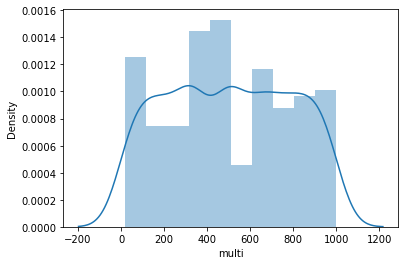

In [19]:
sns.distplot(rank_df["multi"])

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='variants_with_clone_norm_by_1_over_nclones_with_variant', ylabel='Density'>

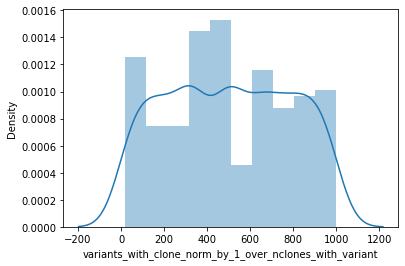

In [20]:
sns.distplot(rank_df["variants_with_clone_norm_by_1_over_nclones_with_variant"])

In [21]:
def get_top_n_results(results_df, rank_df, n=12):
    filt_rank = rank_df.sort_values(by=["multi"])[::-1].iloc[:n]
    filt_results = results_df.loc[filt_rank.index]
    return filt_rank, filt_results


In [22]:
filt_rank, filt_results = get_top_n_results(results_df, rank_df, n=topn)


filt_results = pd.merge(filt_results, full_params, left_index=True, right_index=True, how="left", suffixes=["_obj", ""])
filt_rank = filt_rank.loc[filt_results.index]
filt_results

,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,multi,pct_thresh,other_pct_thresh,af_thresh
1521,0.004518,0.003624,0.004319,0.000348,0.001695,0.004518,0.155,0.805,0.055
1780,0.004384,0.005091,0.004150,0.000460,0.000958,0.004384,0.205,0.455,0.005
1960,0.004324,0.004603,0.004105,0.000460,0.001905,0.004324,0.205,0.905,0.005
1840,0.004324,0.004603,0.004105,0.000460,0.001274,0.004324,0.205,0.605,0.005
1760,0.004306,0.004457,0.004059,0.000460,0.000853,0.004306,0.205,0.405,0.005
1380,0.004248,0.004238,0.004665,0.000348,0.000958,0.004248,0.155,0.455,0.005
583,0.004247,0.001701,0.004251,0.000123,0.000958,0.004247,0.055,0.455,0.155
743,0.004247,0.001701,0.004251,0.000123,0.001800,0.004247,0.055,0.855,0.155
503,0.004229,0.001554,0.004203,0.000123,0.000537,0.004229,0.055,0.255,0.155
483,0.004229,0.001554,0.004203,0.000123,0.000432,0.004229,0.055,0.205,0.155


In [23]:
all_df = []
all_objs = {}
for ind, val in filt_results.iterrows():
    print(ind)
    obj_out, data = evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
    all_df.append(data["all_unique_df"])
    all_objs[ind] = obj_out 
all_df = pd.concat(all_df)

1521
1780
1960
1840
1760
1380
583
743
503
483
1460
1400
1520
1540
1122
1042


In [24]:
# all_df = all_unique

## Either re-run results for top to get unique_df for each param, or store in a dict (harder b/c of the parallel apply). After, need to make all_df by concatenating the results.
Plot A: heatmap FacetGrid, but each axis is a combination of the parameters (can I do col=["colA", "colC"]?


In [25]:
heatmap_input = all_df[["n_cells", "variant"]].reset_index().pivot(index="id", columns="variant", values="n_cells").fillna(0).astype(int)
meta_df = all_df[["af_thresh", "other_pct_thresh", "pct_thresh", "clone"]]
meta_df = meta_df.loc[~(meta_df.index.duplicated())]
meta_df = meta_df.sort_values(["af_thresh","pct_thresh", "other_pct_thresh", "clone"])
heatmap_input = heatmap_input.loc[meta_df.index]

# Get the variants based on total number of cells across parameters
heatmap_input = heatmap_input.loc[:,heatmap_input.sum().sort_values()[::-1].index]
variants_order = heatmap_input.columns

# Get the clones based on total number of cells across parameters
def clone_sum(val):
    #print(val)
    return(heatmap_input.loc[val.index].sum())

clone_sums = meta_df.groupby("clone").apply(clone_sum)
clone_sums = clone_sums.loc[:, clone_sums.sum().sort_values()[::-1].index]
clones_order = clone_sums.index
clones_order



Index(['0_0', '0_1', '0_12', '0_13', '0_14', '0_15', '0_16', '0_17', '0_18',
       '0_19', '0_2', '0_20', '0_21', '0_22', '0_23', '0_24', '0_25', '0_26',
       '0_27', '0_28', '0_29', '0_3', '0_30', '0_31', '0_32', '0_33', '0_4',
       '0_5', '0_6'],
      dtype='object', name='clone')

In [26]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    #param_names = kwargs.pop('param_names', None)
    print(data.shape)
    d = data.pivot(index=args[1], columns=args[0], values=args[2]).fillna(0)
    
    d_full = pd.DataFrame(index=clones_order, columns=variants_order)
    d_full.loc[:,:] = 0
    d_full.loc[d.index,d.columns] = d
    d_full = d_full.astype(float)
    

    plt.title(data["params"].values[0])
    #print(d_full.head())
    
    sns.heatmap(d_full, cbar_kws = dict(orientation="vertical"), **kwargs)
    return

## Create column with all parameter names and use that for facet.

In [27]:
def params_to_str(ser, param_names):
    name = ""
    for p in param_names:
        name = name + f"{p}={ser[p]:.3f}\n"
    return name

In [28]:
all_df["params"] = all_df.apply(params_to_str, axis=1, args=(param_names,))
all_df.head()

filt_results["params"] = filt_results.apply(params_to_str, axis=1, args=(param_names,))
filt_results

,variants_with_clone_norm_by_1_over_nclones_with_variant,max_clone_ncells_over_nclones,max_clone_ncells_over_ncells,pct_thresh_obj,other_pct_thresh_obj,multi,pct_thresh,other_pct_thresh,af_thresh,params
1521,0.004518,0.003624,0.004319,0.000348,0.001695,0.004518,0.155,0.805,0.055,pct_thresh=0.155\naf_thresh=0.055\nother_pct_t...
1780,0.004384,0.005091,0.004150,0.000460,0.000958,0.004384,0.205,0.455,0.005,pct_thresh=0.205\naf_thresh=0.005\nother_pct_t...
1960,0.004324,0.004603,0.004105,0.000460,0.001905,0.004324,0.205,0.905,0.005,pct_thresh=0.205\naf_thresh=0.005\nother_pct_t...
1840,0.004324,0.004603,0.004105,0.000460,0.001274,0.004324,0.205,0.605,0.005,pct_thresh=0.205\naf_thresh=0.005\nother_pct_t...
1760,0.004306,0.004457,0.004059,0.000460,0.000853,0.004306,0.205,0.405,0.005,pct_thresh=0.205\naf_thresh=0.005\nother_pct_t...
1380,0.004248,0.004238,0.004665,0.000348,0.000958,0.004248,0.155,0.455,0.005,pct_thresh=0.155\naf_thresh=0.005\nother_pct_t...
583,0.004247,0.001701,0.004251,0.000123,0.000958,0.004247,0.055,0.455,0.155,pct_thresh=0.055\naf_thresh=0.155\nother_pct_t...
743,0.004247,0.001701,0.004251,0.000123,0.001800,0.004247,0.055,0.855,0.155,pct_thresh=0.055\naf_thresh=0.155\nother_pct_t...
503,0.004229,0.001554,0.004203,0.000123,0.000537,0.004229,0.055,0.255,0.155,pct_thresh=0.055\naf_thresh=0.155\nother_pct_t...
483,0.004229,0.001554,0.004203,0.000123,0.000432,0.004229,0.055,0.205,0.155,pct_thresh=0.055\naf_thresh=0.155\nother_pct_t...


(50, 12)
(38, 12)
(48, 12)
(48, 12)
(35, 12)
(59, 12)
(53, 12)
(53, 12)
(40, 12)
(40, 12)
(69, 12)
(69, 12)
(69, 12)
(69, 12)
(45, 12)
(45, 12)


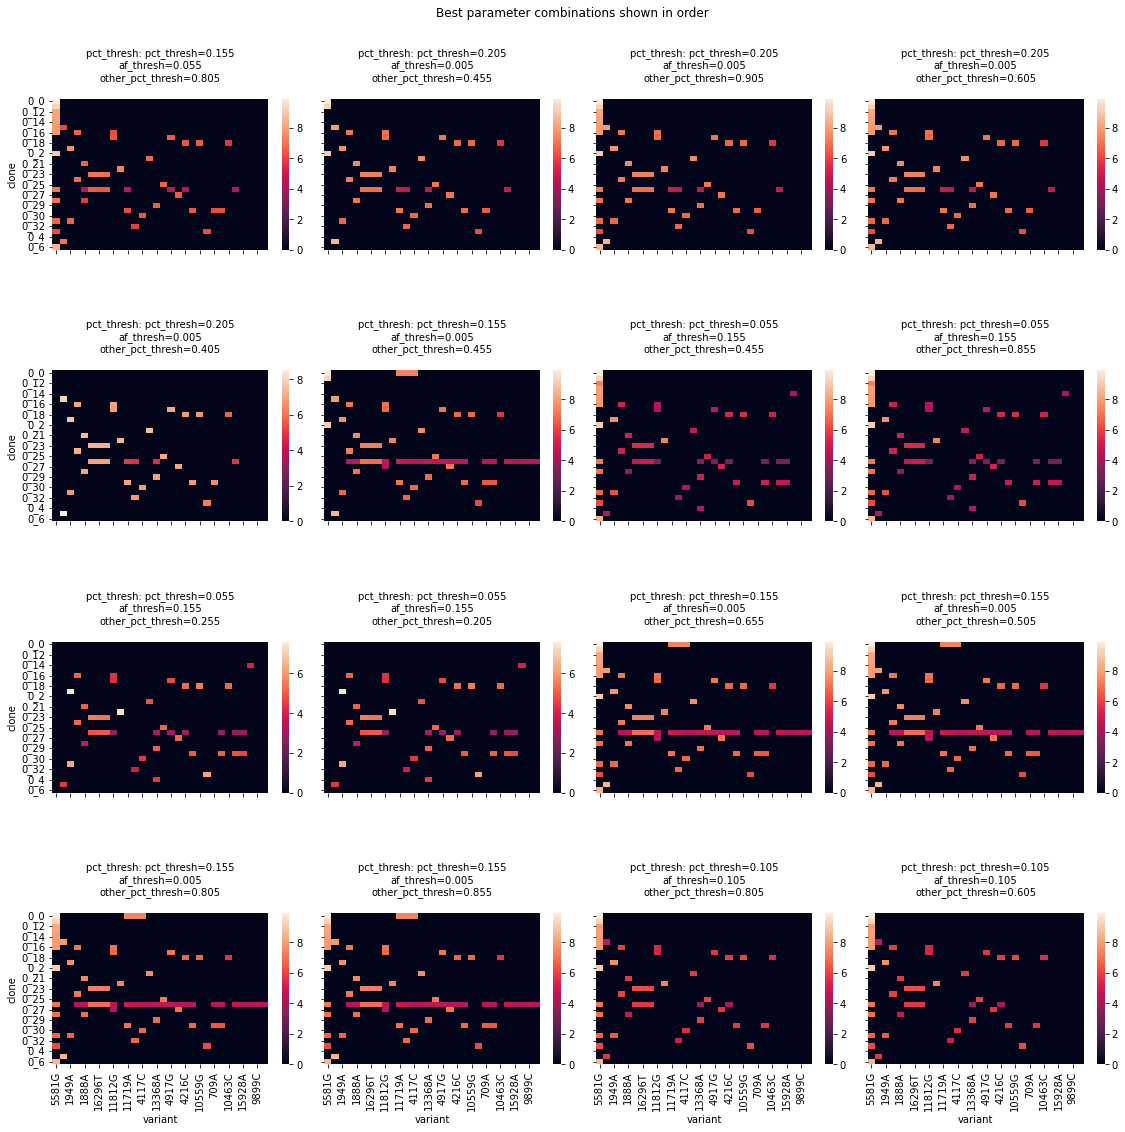

In [29]:
fg = sns.FacetGrid(data=all_df.reset_index(), height=4, 
                   col="params", col_wrap=4, col_order=filt_results["params"].values,margin_titles=True)

fg.map_dataframe(draw_heatmap, 'variant','clone', 'log2_n_cells')#, cbar=False)
fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=0.9, hspace = 0.8)


---

# Using GA

In [30]:
# ## Initialize ga

# pool = multiprocessing.Pool(processes=16)



# # the random initialization of the genetic algorithm is done here
# # it gives a list of integers with for each products the number of times it is bought

# lower_bounds = [0,0,0]
# upper_bounds = [1,1,1]


# def init_pop(n):
#     return list(np.random.random(size=n))


# def evaluate(individual, AF_df, DP_df, curr_labels):
#     ic('individual before', individual)
#     ic(len(individual))
#     individual = individual[0]
#     ic('individual after', individual)
#     ic(len(individual))
#     #pct_thresh, af_thresh, other_pct_thresh = individual["pct_thresh"], individual["af_thresh"], individual["other_pct_thresh"] #solution[0], solution[1], solution[2]
    
#     solution = {"pct_thresh": individual[0], "af_thresh":individual[1],  "other_pct_thresh": individual[2]}
#     #data = 
#     data = {"AF_df": AF_df, "DP_df":DP_df, "curr_labels":curr_labels} 
#     all_unique_df = get_clones_unique_variants(solution, data)
#     data["all_unique_df"] = all_unique_df
#     eval_out = _objectives(data)
#     return tuple(eval_out.values())

# def checkBounds(min, max):
#     def decorator(func):
#         def wrapper(*args, **kargs):
#             offspring = func(*args, **kargs)
#             for child in offspring:
#                 for i in range(len(child)):
#                     if child[i] > max[i]:
#                         child[i] = max[i]
#                     elif child[i] < min[i]:
#                         child[i] = min[i]
#             return offspring
#         return wrapper
#     return decorator

# #from scoop import futures

# # this is the setup of the deap library: registering the different function into the toolbox
# creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, 2.0, 1.0, 1.0))
# creator.create("Individual", list, fitness=creator.FitnessMulti)

# toolbox = base.Toolbox()

# #toolbox.register("map", futures.map)
# toolbox.register("n_per_product", init_pop, n=n_params)

# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.n_per_product, n=n_params)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# toolbox.register("evaluate", evaluate, AF_df=AF_df, DP_df=DP_df, curr_labels=curr_labels)

# toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
# toolbox.register("select", tools.selTournament, tournsize=3)

# # toolbox.register("mate", tools.cxBlend, alpha=0.2)
# # toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=2, indp=0.05)

# # LOWER AND UPPER BOUNDs
# toolbox.decorate("mate", checkBounds(lower_bounds, upper_bounds))
# toolbox.decorate("mutate", checkBounds(lower_bounds, upper_bounds))

# toolbox.register("map", pool.map)


# stats = tools.Statistics(key=lambda ind: ind.fitness.values)
# stats.register("avg", np.mean)
# stats.register("std", np.std)
# stats.register("min", np.min)
# stats.register("max", np.max)

# # logbook = tools.Logbook()
# # logbook.record(gen=0, evals=30, **record)
# # import pickle
# # pickle.dump(logbook, lb_file)

# ## Run

# ## V01 - using pre-defined algorithms

# # this is the definition of the total genetic algorithm is executed, it is almost literally copied from the deap library
# def main():
#     pop = toolbox.population(n=10)
#     pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=3, 
#                                        stats=stats, verbose=True)

# best_solution = main()

# #products_table['univariate_choice'] = pd.Series(best_solution[0])
# #products_table.head()
# pd.Series(best_solution[0])

# ## V02 - using main function taken from site

# # this is the definition of the total genetic algorithm is executed, it is almost literally copied from the deap library
# def main():
#     pop = toolbox.population(n=300)
    
#     # Evaluate the entire population
#     fitnesses = list(map(toolbox.evaluate, pop))
#     for ind, fit in zip(pop, fitnesses):
#         ind.fitness.values = fit

#     # CXPB  is the probability with which two individuals
#     #       are crossed
#     #
#     # MUTPB is the probability for mutating an individual
#     CXPB, MUTPB = 0.5, 0.2
    
#     # Extracting all the fitnesses of 
#     fits = [ind.fitness.values[0] for ind in pop]
    
#     # Variable keeping track of the number of generations
#     g = 0
    
#     # Begin the evolution
#     while g < 5:
#         # A new generation
#         g = g + 1
#         print("-- Generation %i --" % g)
        
#         # Select the next generation individuals
#         offspring = toolbox.select(pop, len(pop))
#         # Clone the selected individuals
#         offspring = list(map(toolbox.clone, offspring))
        
#         # Apply crossover and mutation on the offspring
#         for child1, child2 in zip(offspring[::2], offspring[1::2]):
#             if random.random() < CXPB:
#                 toolbox.mate(child1[0], child2[0])
#                 del child1.fitness.values
#                 del child2.fitness.values

#         for mutant in offspring:
#             if random.random() < MUTPB:
#                 toolbox.mutate(mutant[0])
#                 del mutant.fitness.values
            
#         # Evaluate the individuals with an invalid fitness
#         invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#         fitnesses = map(toolbox.evaluate, invalid_ind)
#         for ind, fit in zip(invalid_ind, fitnesses):
#             ind.fitness.values = fit
            
#         pop[:] = offspring
        
#         # Gather all the fitnesses in one list and print the stats
#         fits = [ind.fitness.values[0] for ind in pop]
        
#         length = len(pop)
#         mean = sum(fits) / length
#         sum2 = sum(x*x for x in fits)
#         std = abs(sum2 / length - mean**2)**0.5
        
#         ic(min(fits), max(fits), mean, std)
    
#     best = pop[np.argmax([toolbox.evaluate(x) for x in pop])]
#     return best

# best_solution = main()

# #products_table['univariate_choice'] = pd.Series(best_solution[0])
# #products_table.head()
# pd.Series(best_solution[0])